In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from copy import deepcopy, copy
import sqlite3
from test import sensitivity_plots
import plotly.express as px

In [34]:
def add_energy(db, original_df):
    index_column = 'event_no'
    truth_table = 'truth'
    df = deepcopy(original_df)
    df = [df_i.sort_values(index_column).reset_index(drop = True) for df_i in df]
    
    if all((df_i[index_column] == df[0][index_column]).all() for df_i in df[1:]):
        with sqlite3.connect(db) as con:
            query = f'select {index_column}, energy from {truth_table} where {index_column} in {str(tuple(df[0][index_column]))}'
            truth = pd.read_sql(query,con).sort_values(index_column).reset_index(drop = True)
    else:
        warnings.warn('The DataFrames do not have the same index', UserWarning)
        for idx, df_i in enumerate(df):
            with sqlite3.connect(db) as con:
                query = f'select {index_column}, energy from {truth_table} where {index_column} in {str(tuple(df_i[index_column]))}'
                truth = pd.read_sql(query,con).sort_values(index_column).reset_index(drop = True)
                
    for idx, df_i in enumerate(df):
        for column in truth.columns:
            if column not in df_i.columns:
                df[idx][column] = truth[column]
    return df

## Prediction of IceMix models on northern tracks 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from copy import deepcopy, copy
import sqlite3
from test import sensitivity_plots
import plotly.express as px

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from copy import deepcopy, copy
from typing import Union, List
import warnings
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

class sensitivity_plots:
    def __init__(self, 
                 df_original: Union[pd.DataFrame, List[pd.DataFrame]], 
                 df_labels: Union[str, List[str]],
                 db: str,
                 pulsemaps:str = 'InIceDSTPulses',
                 index_column: str = 'event_no',
                 x_pred_label: str = 'direction_x',
                 y_pred_label: str = 'direction_y',
                 z_pred_label: str = 'direction_z',
                 truth_table = 'truth',
                 compare_spline: bool = True,
                 cascades_in_dataset: bool = False):
        if isinstance(df_original, pd.DataFrame):
            df_original = [df_original]
        if not isinstance(df_original, list):
            raise TypeError('df_original must be a pandas DataFrame or a list of DataFrames')
        if not isinstance(db, str):
            raise TypeError('database must be a string')
        
        self.db = db
        self.pulsemaps = pulsemaps
        self.index_column = index_column
        self.x_pred_label = x_pred_label
        self.y_pred_label = y_pred_label
        self.z_pred_label = z_pred_label
        self.truth_table = truth_table
        self.compare_spline = compare_spline
        self.cascades_in_dataset = cascades_in_dataset
        df_new = copy(df_original)
        df_labels_new = copy(df_labels)
        
        if compare_spline:
            df_new.insert(0, df_new[-1])
            df_labels_new.insert(0, 'SplineMPE')
        
        self.df_labels = deepcopy(df_labels_new)
        if 'energy' not in df_new[0].columns:
            df_new = self._add_energy(df_new)
        if 'track' not in df_new[0].columns:
            df_new = self._add_track_label(df_new)
        if 'azimuth_pred' not in df_new[0].columns:
            df_new = [self._add_prediction_azimuth_zenith(df_i) if ('zenith_pred' not in df_i.columns) else df_i for df_i in df_new]
        if self.compare_spline:
            df_new[0] = self._add_spline_fit(df_new[0])
    
        self.df_original = deepcopy(df_new)
       
    def _add_energy(self, original_df: List[pd.DataFrame]):
        df = deepcopy(original_df)
        df = [df_i.sort_values(self.index_column).reset_index(drop = True) for df_i in df]
        
        if all((df_i[self.index_column] == df[0][self.index_column]).all() for df_i in df[1:]):
            with sqlite3.connect(self.db) as con:
                query = f'select {self.index_column}, energy from {self.truth_table} where {self.index_column} in {str(tuple(df[0][self.index_column]))}'
                truth = pd.read_sql(query,con).sort_values(self.index_column).reset_index(drop = True)
        else:
            warnings.warn('The DataFrames do not have the same index', UserWarning)
            for idx, df_i in enumerate(df):
                with sqlite3.connect(self.db) as con:
                    query = f'select {self.index_column}, energy from {self.truth_table} where {self.index_column} in {str(tuple(df_i[self.index_column]))}'
                    truth = pd.read_sql(query,con).sort_values(self.index_column).reset_index(drop = True)
                    
        for idx, df_i in enumerate(df):
            for column in truth.columns:
                if column not in df_i.columns:
                    df[idx][column] = truth[column]
        return df
    
    def _add_track_label(self, original_df: List[pd.DataFrame]):
        df = deepcopy(original_df)
        df = [df_i.sort_values(self.index_column).reset_index(drop = True) for df_i in df]
        
        if all((df_i[self.index_column] == df[0][self.index_column]).all() for df_i in df[1:]):
            with sqlite3.connect(self.db) as con:
                query = f'select {self.index_column}, interaction_type, pid from {self.truth_table} where {self.index_column} in {str(tuple(df[0][self.index_column]))}'
                truth = pd.read_sql(query,con).sort_values(self.index_column).reset_index(drop = True)
                truth['track'] = 0
                truth.loc[(truth['interaction_type'] == 1) & (abs(truth['pid']) == 14), 'track'] = 1
        else:
            warnings.warn('The DataFrames do not have the same index', UserWarning)
            for idx, df_i in enumerate(df):
                with sqlite3.connect(self.db) as con:
                    query = f'select {self.index_column}, interaction_type, pid from {self.truth_table} where {self.index_column} in {str(tuple(df_i[self.index_column]))}'
                    truth = pd.read_sql(query,con).sort_values(self.index_column).reset_index(drop = True)
                    truth['track'] = 0
                    truth.loc[(truth['interaction_type'] == 1) & (abs(truth['pid']) == 14), 'track'] = 1
                            
        for idx, df_i in enumerate(df):
            for column in truth.columns:
                if column not in df_i.columns:
                    df[idx][column] = truth[column]
        
        return df

    def _add_spline_fit(self, original_df: pd.DataFrame):
        df = deepcopy(original_df)
        df = df.sort_values(self.index_column).reset_index(drop = True)
        with sqlite3.connect(self.db) as con:
            # Read the table data into a Pandas DataFrame
            query = f'SELECT {self.index_column}, zenith_spline_mpe_ic, azimuth_spline_mpe_ic from spline_mpe_ic where {self.index_column} in {str(tuple(df[self.index_column]))}'
            truth = pd.read_sql(query,con).sort_values(self.index_column).reset_index(drop = True)
            # Add the spline fit to the DataFrame
            for column in truth.columns:
                if column not in df.columns:
                    df[column] = truth[column]    
        return df
    
    #def _add_prediction_azimuth_zenith(self, original_df):
    #    df = deepcopy(original_df)
    #    #df = df.sort_values(index_column).reset_index(drop = True)
    #    pred = np.stack([df[self.x_pred_label].values, df[self.y_pred_label].values, df[self.z_pred_label].values], axis=-1)
    #    pred = np.divide(pred.astype(float), np.linalg.norm(pred.astype(float), ord=2, axis=-1, keepdims=True))
    #    
    #    zen = np.arccos(np.clip(pred[:, 2], -1, 1))
    #    
    #    f = np.divide(pred[:, :2], np.linalg.norm(pred[:, :2], ord=2, axis=-1, keepdims=True))
    #    
    #    az = np.arcsin(np.clip(f[:, 0], -1, 1))
    #    az = np.where(f[:, 1] > 0, az, np.pi - az)
    #    az = np.where(az > 0, az, az + 2.0 * np.pi)
    #    df['zenith_pred'] = zen
    #    df['azimuth_pred'] = az
    #    
    #    return df
        
    def _add_prediction_azimuth_zenith(self, original_df):
        df = deepcopy(original_df)
        df = df.sort_values(self.index_column).reset_index(drop = True)
            
        magnitude = np.sqrt(df[self.x_pred_label]**2 + df[self.y_pred_label]**2 + df[self.z_pred_label]**2)
        zenith_pred = np.arccos(df[self.z_pred_label] / magnitude)
        azimuth_pred = np.arctan2(df[self.y_pred_label], df[self.x_pred_label])
        
        zenith_pred = np.where(zenith_pred < 0, 2*np.pi + zenith_pred, zenith_pred)
        azimuth_pred = np.where(azimuth_pred < 0, 2*np.pi + azimuth_pred, azimuth_pred)
        df['zenith_pred'] = np.where(zenith_pred >= 2*np.pi, zenith_pred - 2*np.pi, zenith_pred)
        df['azimuth_pred'] = np.where(azimuth_pred >= 2*np.pi, azimuth_pred - 2*np.pi, azimuth_pred)
        
        return df


    def _calculate_percentiles(self, percentile_calculations_original, residual, key1, key2, index = None):
        percentile_calculations = deepcopy(percentile_calculations_original)
        if index is None:
            percentile_calculations[key1][key2]['p_16'].append(np.percentile(residual, 16))
            percentile_calculations[key1][key2]['p_84'].append(np.percentile(residual, 84))
            if self.include_median:
                percentile_calculations[key1][key2]['p_50'].append(np.percentile(residual, 50))
            return percentile_calculations
        else:
            if sum(index)>0:
                percentile_calculations[key1][key2]['p_16'].append(np.percentile(residual[index], 16))
                percentile_calculations[key1][key2]['p_84'].append(np.percentile(residual[index], 84))
                if self.include_median:
                    percentile_calculations[key1][key2]['p_50'].append(np.percentile(residual[index], 50))
                return percentile_calculations
            else:
                percentile_calculations[key1][key2]['p_16'].append(np.nan)
                percentile_calculations[key1][key2]['p_84'].append(np.nan)
                if self.include_median:
                    percentile_calculations[key1][key2]['p_50'].append(np.nan)
                return percentile_calculations

    def _calculate_opening_angle(self, df, key = 'gnn'):
        x = np.cos(df['azimuth']) * np.sin(df['zenith'])
        y = np.sin(df['azimuth']) * np.sin(df['zenith'])
        z = np.cos(df['zenith'])
        if key == 'gnn':
            dot_product = x*df[self.x_pred_label] + y*df[self.y_pred_label] + z*df[self.z_pred_label]
            norm = np.sqrt(df[self.x_pred_label]**2 + df[self.y_pred_label]**2 + df[self.z_pred_label]**2)
            angle = np.arccos(dot_product/norm)
        elif key == 'spline':
            x_spline = np.cos(df['azimuth_spline_mpe_ic']) * np.sin(df['zenith_spline_mpe_ic'])
            y_spline = np.sin(df['azimuth_spline_mpe_ic']) * np.sin(df['zenith_spline_mpe_ic'])
            z_spline = np.cos(df['zenith_spline_mpe_ic'])
            dot_product = x*x_spline + y*y_spline + z*z_spline
            norm = np.sqrt(x_spline**2 + y_spline**2 + z_spline**2)
            angle = np.arccos(dot_product/norm)
        return np.rad2deg(angle)

    def plot_variable_count(self, key, fill = True, font_size = 10):
        df = self.df_original
        fig = plt.figure(figsize = (5,3.5), constrained_layout = True)
        ax = fig.add_subplot(111)
        if key == 'energy':
            key_bins = np.arange(0,3.5, 0.1)
            ax.set_xlabel('True Energy [GeV]', size = font_size)
            ax.set_ylabel('Reco. Energy [GeV]', size = font_size)

        if key == 'zenith':
            key_bins = np.arange(-1, 1, 0.05)
            ax.set_xlabel('True  cos(zenith) ', size = font_size)
            ax.set_ylabel('Reco. cos(zenith) ', size = font_size)
            
        if key == 'azimuth':
            key_bins = np.arange(-1, 1, 0.05)
            ax.set_xlabel('True  cos(azimuth) ', size = font_size)
            ax.set_ylabel('Reco. cos(azimuth) ', size = font_size)
        
        pct_16 = []
        pct_84 = []
        pct_50 = []
        means = []
        medians = []
        for k in range(len(key_bins)-1):
            if key == 'energy':
                idx = (np.log10(df[key]) >= key_bins[k]) & (np.log10(df[key])< key_bins[k +1])
                if sum(idx)> 0:
                    pct_16.append(np.percentile(np.log10(df[key+ '_pred'][idx]),16))
                    pct_50.append(np.percentile(np.log10(df[key+ '_pred'][idx]),50))
                    pct_84.append(np.percentile(np.log10(df[key+ '_pred'][idx]),84))
                    means.append(np.mean(np.log10(df[key][idx])))
                    medians.append(np.median(np.log10(df[key][idx])))
            elif key == 'zenith' or key == 'azimuth':
                idx = (np.cos(df[key]) >= key_bins[k]) & (np.cos(df[key])< key_bins[k +1])
                if sum(idx)>0:
                    pct_16.append(np.percentile(np.cos(df[key+ '_pred'][idx]),16))
                    pct_50.append(np.percentile(np.cos(df[key+ '_pred'][idx]),50))
                    pct_84.append(np.percentile(np.cos(df[key+ '_pred'][idx]),84))
                    means.append(np.mean(np.cos(df[key][idx])))
                    medians.append(np.median(np.cos(df[key][idx])))
        
        if key == 'energy':
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.plot(df[key],df[key], label = '1:1', ls = '--', color = 'grey', alpha = 0.5)
            if fill:
                ax.fill_between(10**np.array(means), 10**np.array(pct_16), 10**np.array(pct_84), color = 'tab:blue', alpha = 0.5, label = 'Central 68%')
            #ax.plot(10**np.array(means), 10**np.array(pct_16), label = None, ls = '--', color = 'tab:blue', alpha = 0.8)
            #ax.plot(medians, pct_50, label = '50th', ls = '-', color = 'tab:blue', alpha = 0.8)
            #ax.plot(10**np.array(means), 10**np.array(pct_84), label = None, ls = '-.', color = 'tab:blue', alpha = 0.8)
            ax.plot(10**np.array(means), 10**np.array(pct_50), label = 'Median', ls = '-', color = 'tab:blue', alpha = 1)
            
        if key == 'zenith':
            ax.plot(np.cos(df[key]),np.cos(df[key]), label = '1:1', ls = '--', color = 'grey', alpha = 0.5)
            if fill:
                ax.fill_between(x = means, y1 = pct_84, y2 = pct_16, color = 'tab:blue', alpha = 0.5, label = 'Central 68%')
        
            ax.plot(means, pct_16, label = None, ls = '--', color = 'tab:blue', alpha = 0.8)
            ax.plot(means, pct_84, label = None, ls = '-.', color = 'tab:blue', alpha = 0.8)
            
            ax.plot(means, pct_50, label = 'Median', ls = '-', color = 'tab:blue', alpha = 1)
            ax.plot(medians, pct_50, label = '50th', ls = '-', color = 'tab:blue', alpha = 0.8)
            
        if key == 'azimuth':
            ax.plot(np.cos(df[key]),np.cos(df[key]), label = '1:1', ls = '--', color = 'grey', alpha = 0.5)
            if fill:
                ax.fill_between(x = means, y1 = pct_84, y2 = pct_16, color = 'tab:blue', alpha = 0.5, label = 'Central 68%')
        
            ax.plot(means, pct_16, label = None, ls = '--', color = 'tab:blue', alpha = 0.8)
            ax.plot(means, pct_84, label = None, ls = '-.', color = 'tab:blue', alpha = 0.8)
            
            ax.plot(means, pct_50, label = 'Median', ls = '-', color = 'tab:blue', alpha = 1)
        ax.legend(frameon = False, fontsize = font_size)
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #plt.text(x = text_loc[0], y = text_loc[1], s = "IceCube Simulation", fontsize = 12)
        #plt.rcParams['xtick.labelsize'] = 10
        #plt.rcParams['ytick.labelsize'] = 10 
        #plt.rcParams['axes.labelsize'] = 10
        #plt.rcParams['axes.titlesize'] = 12
        #plt.rcParams['legend.fontsize'] = 10
        #fig.savefig(f'2d_correlation_performance{key}.pdf')
        #fig.savefig(f'2d_correlation_performance{key}.png')
    def plot_resolution_fancy(self, 
                            key: str = 'direction',
                            include_median: bool = True, 
                            include_energy_hist: bool = False,
                            step: bool = True,
                            include_residual_hist:bool = False,
                            font_size: int = 10, 
                            y_limits = None,
                            x_limits = None,
                            fill_area: bool = False):

        df = deepcopy(self.df_original)
        df_labels_plotting = deepcopy(self.df_labels)
        self.include_median = include_median
        
        plotting_colours = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
        track_index = [i for i in range(len(df))]
        track_colour = [plotting_colours[i % len(plotting_colours)] for i in track_index]
        cascade_index = [len(df)+i+1 for i in range(len(df))]
        cascade_colour = [plotting_colours[i % len(plotting_colours)] for i in cascade_index]
        all_colour = {'track': track_colour, 'cascade': cascade_colour}
        
        percentiles = ['p_16', 'p_84']
        if include_median:
            percentiles.append('p_50')
        percentile_calculations = {'tracks': {f'{df_labels_plotting[i]}': {percentile: [] for percentile in percentiles+['mean_energy']} for i in range(len(df))}}
        if self.cascades_in_dataset:
            percentile_calculations['cascades'] = {f'{df_labels_plotting[i]}': {percentile: [] for percentile in percentiles+['mean_energy']} for i in range(len(df))}
        
        fig = plt.figure(figsize = (5,3.5), constrained_layout = True)
        if include_energy_hist:
            gs = fig.add_gridspec(10, 10)
            ax = fig.add_subplot(gs[2:, :])
            ax_histx = fig.add_subplot(gs[0:2, :], sharex=ax)
            ax2 = fig.add_subplot(gs[2:10, 6:])
        elif include_residual_hist:
            gs = fig.add_gridspec(8, 10)
            ax = fig.add_subplot(gs[0:, :-4])
            ax_histx = None
            ax2 = fig.add_subplot(gs[0:8, 6:])
        else:
            gs = fig.add_gridspec(8, 6)
            ax = fig.add_subplot(gs[0:, :6])
            ax_histx = None
            ax2 = None
            for i in range(len(df)):
                label = [None if fill_area else f'Tracks {df_labels_plotting[i]}'][0]
                ax.plot(np.nan, np.nan, color = all_colour['track'][i], label = label)
                if self.cascades_in_dataset:
                    ax.plot(np.nan, np.nan, color = all_colour['cascade'][i], label = label)

            
            
        for i in range(len(df)):
            percentile_calculations['tracks'][df_labels_plotting[i]]['colour'] = all_colour['track'][i]
            if self.cascades_in_dataset:
                percentile_calculations['cascades'][df_labels_plotting[i]]['colour'] = all_colour['cascade'][i]
        
        
        energy_bins = []# , np.arange(0,3.1,0.05)
        for percentile in np.arange(0,102.5,2.5):
        #for percentile in np.arange(0,105,5):
            energy_bins.append(np.percentile(np.log10(df[0]['energy']), percentile))

        # Calculate the residuals and bins
        residual = {}
        keys_df = list(percentile_calculations['tracks'].keys())
        for idx, df_i in enumerate(df):
            key_df = keys_df[idx]
            if key == 'energy':
                if not (self.compare_spline and idx == 0):
                    residual[key_df] = ((df_i['energy'] - df_i['energy_pred'])/df_i['energy']) * 100
                    key_bins = np.arange(-300,100, 5)
                    if ax2 is not None:
                        ax2.set_xlabel('$\\frac{Truth - Reco.}{Truth}$[%]', size = font_size)
                    ax.set_ylabel('Energy Resolution [%]', size = font_size)
                    plt.title('Energy resolution on NT dataset')
            elif key == 'zenith':
                if self.compare_spline and idx == 0:
                    residual['SplineMPE'] = (np.rad2deg(df_i['zenith'] - df_i['zenith_spline_mpe_ic']))
                else:
                    residual[key_df] = np.rad2deg(df_i['zenith'] - df_i['zenith_pred'])
                key_bins = np.arange(-90, 90, 1)
                if ax2 is not None:
                    ax2.set_xlabel('Truth - Reco. [deg.]', size = font_size)
                ax.set_ylabel('Zenith Resolution [deg.]', size = font_size)
                plt.title('Zenith resolution on NT dataset')
            elif key == 'azimuth':
                if self.compare_spline and idx == 0:
                    residual['SplineMPE'] = (np.rad2deg(df_i['azimuth'] - df_i['azimuth_spline_mpe_ic']))
                else:
                    residual[key_df] = np.rad2deg(df_i['azimuth'] - df_i['azimuth_pred'])
                key_bins = np.arange(-90, 90, 1)
                if ax2 is not None:
                    ax2.set_xlabel('Truth - Reco. [deg.]', size = font_size)
                ax.set_ylabel('Azimuth Resolution [deg.]', size = font_size)
                plt.title('Azimuth resolution on NT dataset')
            elif key == 'direction':
                if self.compare_spline and idx == 0:
                    residual['SplineMPE'] = self._calculate_opening_angle(df_i, key = 'spline')
                else:
                    residual[key_df] = self._calculate_opening_angle(df_i, key = 'gnn')
                key_bins = np.arange(0, 120, 1)
                if ax2 is not None:
                    ax2.set_xlabel('Opening Angle [deg.]', size = font_size)
                ax.set_ylabel('Opening Angle [deg.]', size = font_size)
                plt.title('Opening angle resolution on NT dataset', fontdict={'fontsize': font_size+2})
            else:
                assert False, "key must be 'energy', 'zenith', 'azimuth' or 'direction'"

        for idx, df_i in enumerate(df):
            for i in range(len(energy_bins) - 1):
                index_energy = (np.log10(df_i['energy'])>= energy_bins[i]) & (np.log10(df_i['energy'])<energy_bins[i+1])                    
                for event_type in percentile_calculations.keys():
                    index = np.where(event_type == 'tracks', df_i['track'][index_energy] == 1, df_i['track'][index_energy] == 0)
                    percentile_calculations = self._calculate_percentiles(percentile_calculations, residual[df_labels_plotting[idx]][index_energy], event_type, df_labels_plotting[idx], index = index)
                    percentile_calculations[event_type][df_labels_plotting[idx]]['mean_energy'].append(np.log10(df_i['energy'][index_energy][index]).mean())       
                    
        self.residual = residual        
        
        for event_type in list(percentile_calculations.keys()):
            for pred_name in list(percentile_calculations[event_type].keys()):
                for percentile in percentiles+['mean_energy']:
                    percentile_calculations[event_type][pred_name][percentile] = np.array(percentile_calculations[event_type][pred_name][percentile])
                    
                    
                    
        for event_type in list(percentile_calculations.keys()):
            for pred_name in list(percentile_calculations[event_type].keys()):
                for percentile in percentiles:
                    ls = '-' if percentile == 'p_50' else '--'
                    if percentile == 'p_50':
                        if step:
                            ax.step(10**percentile_calculations[event_type][pred_name]['mean_energy'], percentile_calculations[event_type][pred_name][percentile], label=None, ls=ls, color=percentile_calculations[event_type][pred_name]['colour'], where='mid')
                        else:
                            ax.plot(10**percentile_calculations[event_type][pred_name]['mean_energy'], percentile_calculations[event_type][pred_name][percentile], label=None, ls=ls, color=percentile_calculations[event_type][pred_name]['colour'])
                    else:
                        if not fill_area:
                            if step:
                                ax.step(10**percentile_calculations[event_type][pred_name]['mean_energy'], percentile_calculations[event_type][pred_name][percentile], label=None, ls=ls, color=percentile_calculations[event_type][pred_name]['colour'], where='mid')
                            else:
                                ax.plot(10**percentile_calculations[event_type][pred_name]['mean_energy'], percentile_calculations[event_type][pred_name][percentile], label=None, ls=ls, color=percentile_calculations[event_type][pred_name]['colour'])
                if fill_area:
                    ax.fill_between(10**percentile_calculations[event_type][pred_name]['mean_energy'], percentile_calculations[event_type][pred_name]['p_16'], percentile_calculations[event_type][pred_name]['p_84'], 
                                    color=percentile_calculations[event_type][pred_name]['colour'], alpha=0.2, label=pred_name)


        self.percentile_calculations = percentile_calculations
        if not fill_area:
            ax.plot(np.nan, np.nan, label = '84th', ls = '--', color = 'grey')
        if include_median:
            ax.plot(np.nan, np.nan, label = 'Median', ls = '-', color = 'grey')
        
        if include_energy_hist:
            for idx, df_i in enumerate(df):
                ax_histx.hist(np.log10(df_i['energy'][df_i['track'] == 1]), histtype = 'step', color = track_colour[idx], bins = energy_bins)

        ax.legend(frameon = False, fontsize = font_size, bbox_to_anchor=None)
        ax.set_xlabel('True Energy [GeV]', size = font_size)
        if ax2 is not None:
            for idx, df_i in enumerate(df):
                key_df = keys_df[idx]
                ax2.hist(residual[df['track'] == 1], histtype = 'step', bins = key_bins, label = 'Tracks')
                
                
                
            ax2.hist(residual[df['track'] == 1], histtype = 'step', bins = key_bins, label = 'Tracks')
            if self.cascades_in_dataset:
                ax2.hist(residual[df['track'] == 0], histtype = 'step', bins = key_bins, label = 'Cascades')
            if self.compare_spline:
                ax2.hist(residual[df['track'] == 1], histtype = 'step', bins = key_bins, label = 'Tracks (SplineMPE)')
                if self.cascades_in_dataset:
                    ax2.hist(residual[df['track'] == 0], histtype = 'step', bins = key_bins, label = 'Cascades (SplineMPE)')
        
        if key in ['energy', 'zenith', 'azimuth']:
            if ax2 is not None:
                ax2.legend(frameon = False, fontsize = font_size, loc = 'upper left')
        else:
            if ax2 is not None:
                ax2.legend(frameon = False, fontsize = font_size)
    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if include_energy_hist:
            ax_histx.spines['right'].set_visible(False)
            ax_histx.spines['top'].set_visible(False)
            ax_histx.spines['left'].set_visible(False)
            ax_histx.set_yticklabels([])
            plt.setp(ax_histx.get_xticklabels(), visible=False)
            ax_histx.set_xticklabels([])
            ax_histx.set_yticks([])
        if ax2 is not None:
            ax2.spines['left'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            ax2.yaxis.tick_right()
        #plt.suptitle(f'{key.capitalize()}', size = font_size)
        ax.set_xscale('log')
        if y_limits is not None:
            ax.set_ylim(y_limits[0], y_limits[1])
        if x_limits is not None:
            ax.set_xlim(x_limits[0], x_limits[1])

        plt.rcParams['xtick.labelsize'] = 10
        plt.rcParams['ytick.labelsize'] = 10 
        plt.rcParams['axes.labelsize'] = 10
        plt.rcParams['axes.titlesize'] = 12
        plt.rcParams['legend.fontsize'] = 10
        
        plt.rcParams['axes.titlesize'] = 15
        #plt.text(x = text_loc[0], y = text_loc[1], s = "IceCube Simulation", fontsize = 12)
        #fig.savefig(f'{key}_reco.pdf')
        if ax2 is not None:
            return fig, ax, ax2
        else:
            return fig, ax


## Compare model5 baseline weights with a fast-retrain to check everything is okay

In [6]:
df_baseline = pd.read_csv('/remote/ceph/user/l/llorente/IceMix_solution_northern/pred_icemix_model5_baseline_full.csv')
df_retrain = pd.read_csv('/remote/ceph/user/l/llorente/IceMix_solution_northern/pred_icemix_model5_test_retrain_full.csv')


database_dir = '/mnt/scratch/rasmus_orsoe/databases/dev_northern_tracks_muon_labels_v3/'
database = database_dir+'dev_northern_tracks_muon_labels_v3_part_5.db'

all_df = [df_baseline, df_retrain]
all_labels = ['Baseline', 'Retrain']

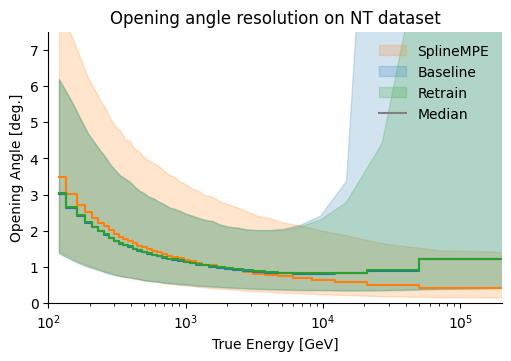

In [7]:
comparison_pred = sensitivity_plots(all_df, all_labels, database, cascades_in_dataset=False, x_pred_label='direction_y', y_pred_label='direction_x', z_pred_label = 'direction_z')
fig, ax = comparison_pred.plot_resolution_fancy('direction', include_residual_hist=False, step=True, y_limits=[0, 7.5], x_limits=[1e2, 10**(5.3)], fill_area=True)

Text(0.5, 1.0, 'Distribution of Predicted - True Zenith Angles')

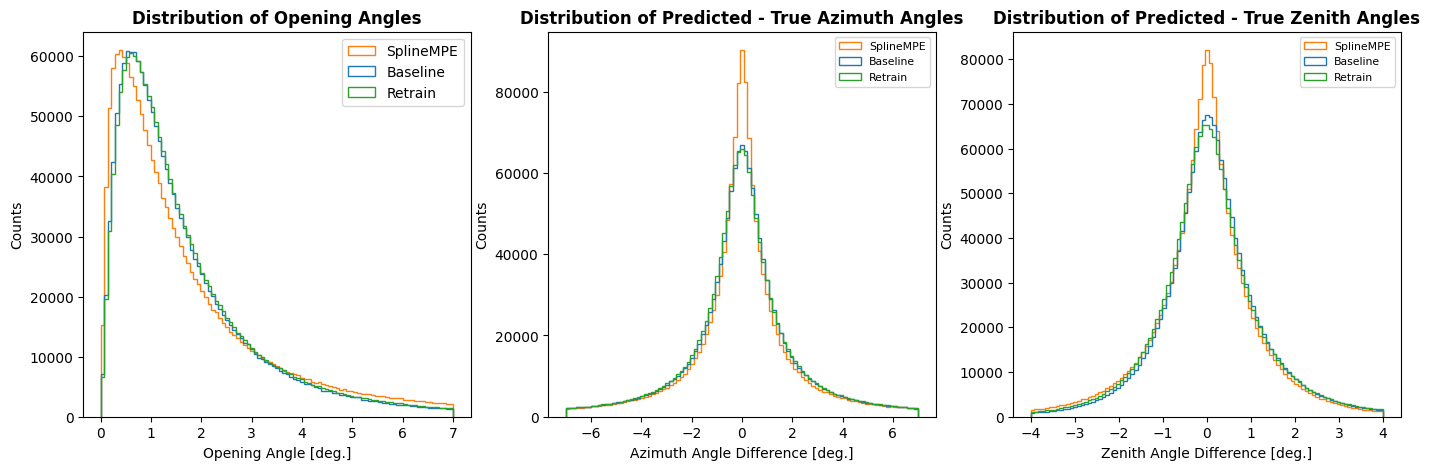

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

bins=np.linspace(0, 7, 100)
for label in comparison_pred.residual.keys():
    ax[0].hist(comparison_pred.residual[label], bins=bins, histtype = 'step', label = label, log=False, color=comparison_pred.percentile_calculations['tracks'][label]['colour'])
ax[0].legend()
ax[0].set_xlabel('Opening Angle [deg.]')
ax[0].set_ylabel('Counts')
ax[0].set_title('Distribution of Opening Angles', fontsize=12, fontweight='bold')

bins=np.linspace(-7, 7, 100)
for i, label in enumerate(comparison_pred.residual.keys()):
    if i == 0:
        ax[1].hist(np.rad2deg(comparison_pred.df_original[0]['azimuth_spline_mpe_ic']-comparison_pred.df_original[0]['azimuth']), bins=bins, histtype = 'step', label = label, log=False, color=comparison_pred.percentile_calculations['tracks'][label]['colour'])
    else:
        ax[1].hist(np.rad2deg(comparison_pred.df_original[i]['azimuth_pred']-comparison_pred.df_original[i]['azimuth']), bins=bins, histtype = 'step', label = label, log=False, color=comparison_pred.percentile_calculations['tracks'][label]['colour'])
ax[1].legend(fontsize=7.8)
ax[1].set_xlabel('Azimuth Angle Difference [deg.]')
ax[1].set_ylabel('Counts')
ax[1].set_title('Distribution of Predicted - True Azimuth Angles', fontsize=12, fontweight='bold')

bins=np.linspace(-4, 4, 100)
for i, label in enumerate(comparison_pred.residual.keys()):
    if i == 0:
        ax[2].hist(np.rad2deg(comparison_pred.df_original[0]['zenith_spline_mpe_ic']-comparison_pred.df_original[0]['zenith']), bins=bins, histtype = 'step', label = label, log=False, color=comparison_pred.percentile_calculations['tracks'][label]['colour'])
    else:
        ax[2].hist(np.rad2deg(comparison_pred.df_original[i]['zenith_pred']-comparison_pred.df_original[i]['zenith']), bins=bins, histtype = 'step', label = label, log=False, color=comparison_pred.percentile_calculations['tracks'][label]['colour'])
ax[2].legend(fontsize=7.8)
ax[2].set_xlabel('Zenith Angle Difference [deg.]')
ax[2].set_ylabel('Counts')
ax[2].set_title('Distribution of Predicted - True Zenith Angles', fontsize=12, fontweight='bold')

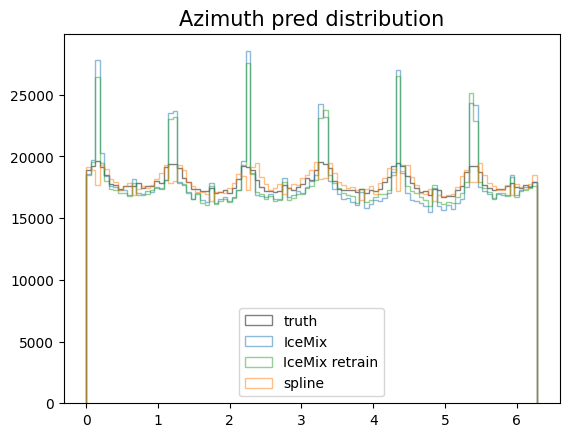

In [15]:
bins = np.linspace(0, 2*np.pi, 100)
log = False
plt.hist(comparison_pred.df_original[0]['azimuth'], bins=bins, alpha=0.5, label='truth', histtype='step', log=log, color='black')
plt.hist(comparison_pred.df_original[1]['azimuth_pred'], bins=bins, alpha=0.5, label='IceMix', histtype='step', log=log, color=comparison_pred.percentile_calculations['tracks'][comparison_pred.df_labels[1]]['colour'])
plt.hist(comparison_pred.df_original[2]['azimuth_pred'], bins=bins, alpha=0.5, label='IceMix retrain', histtype='step', log=log, color=comparison_pred.percentile_calculations['tracks'][comparison_pred.df_labels[2]]['colour'])
plt.hist(comparison_pred.df_original[0]['azimuth_spline_mpe_ic'], bins=bins, alpha=0.5, label='spline', histtype='step', log=log, color=comparison_pred.percentile_calculations['tracks'][comparison_pred.df_labels[0]]['colour'])
plt.title('Azimuth pred distribution')
plt.legend()
plt.show()

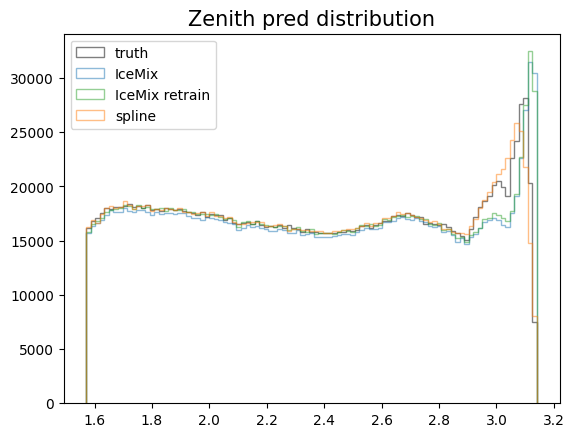

In [17]:
bins = np.linspace(np.pi/2, np.pi, 100)
log = False
plt.hist(comparison_pred.df_original[0]['zenith'], bins=bins, alpha=0.5, label='truth', histtype='step', log=log, color='black')
plt.hist(comparison_pred.df_original[1]['zenith_pred'], bins=bins, alpha=0.5, label='IceMix', histtype='step', log=log, color=comparison_pred.percentile_calculations['tracks'][comparison_pred.df_labels[1]]['colour'])
plt.hist(comparison_pred.df_original[2]['zenith_pred'], bins=bins, alpha=0.5, label='IceMix retrain', histtype='step', log=log, color=comparison_pred.percentile_calculations['tracks'][comparison_pred.df_labels[2]]['colour'])
plt.hist(comparison_pred.df_original[0]['zenith_spline_mpe_ic'], bins=bins, alpha=0.5, label='spline', histtype='step', log=log, color=comparison_pred.percentile_calculations['tracks'][comparison_pred.df_labels[0]]['colour'])
plt.title('Zenith pred distribution')
plt.legend()
plt.show()

In [11]:
df_selected = pd.read_csv('/remote/ceph/user/l/llorente/IceMix_solution_northern/pred_icemix_all_models.csv')

database_dir = '/mnt/scratch/rasmus_orsoe/databases/dev_northern_tracks_muon_labels_v3/'
database = database_dir+'dev_northern_tracks_muon_labels_v3_part_5.db'

all_df = [df_selected]
all_labels = ['IceMix model']

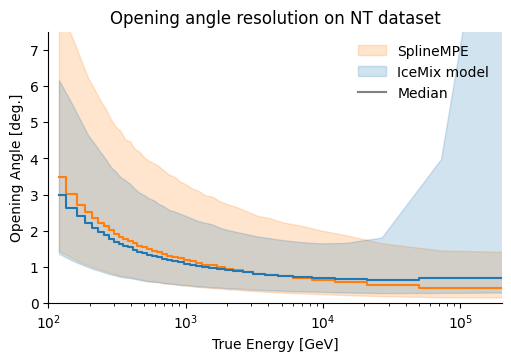

In [12]:
icemix_pred = sensitivity_plots(df_selected, all_labels, database, cascades_in_dataset=False, x_pred_label='direction_y', y_pred_label='direction_x', z_pred_label = 'direction_z')
fig, ax = icemix_pred.plot_resolution_fancy('direction', include_residual_hist=False, step=True, y_limits=[0, 7.5], x_limits=[1e2, 10**(5.3)], fill_area=True)

Text(0.5, 1.0, 'Distribution of Predicted - True Zenith Angles')

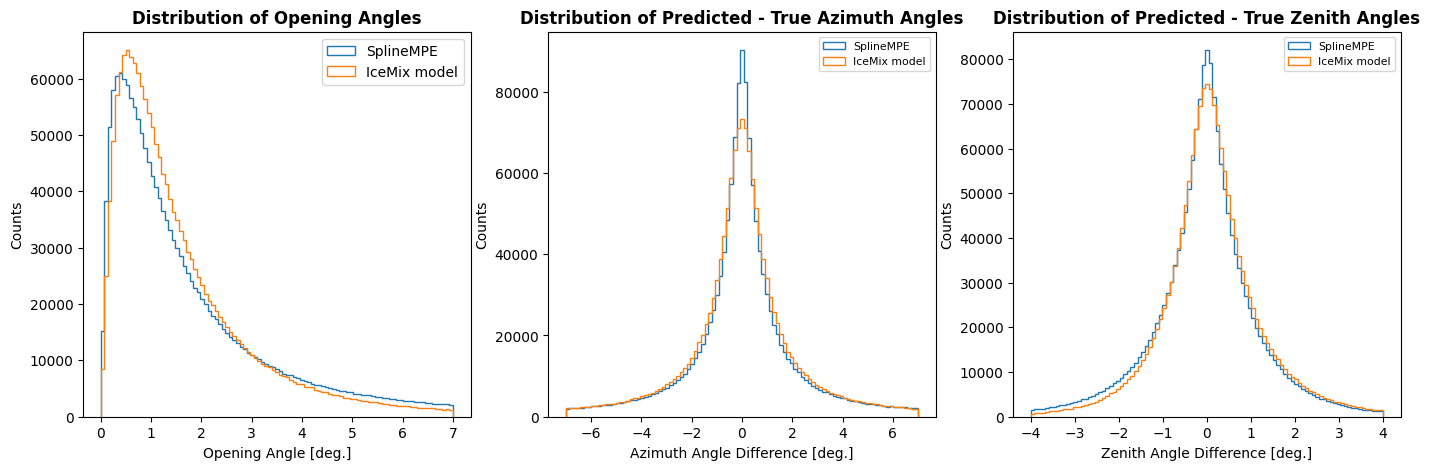

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

bins=np.linspace(0, 7, 100)
for label in icemix_pred.residual.keys():
    ax[0].hist(icemix_pred.residual[label], bins=bins, histtype = 'step', label = label, log=False)
ax[0].legend()
ax[0].set_xlabel('Opening Angle [deg.]')
ax[0].set_ylabel('Counts')
ax[0].set_title('Distribution of Opening Angles', fontsize=12, fontweight='bold')

bins=np.linspace(-7, 7, 100)
for i, label in enumerate(icemix_pred.residual.keys()):
    if i == 0:
        ax[1].hist(np.rad2deg(icemix_pred.df_original[0]['azimuth_spline_mpe_ic']-icemix_pred.df_original[0]['azimuth']), bins=bins, histtype = 'step', label = label, log=False)
    else:
        ax[1].hist(np.rad2deg(icemix_pred.df_original[i]['azimuth_pred']-icemix_pred.df_original[i]['azimuth']), bins=bins, histtype = 'step', label = label, log=False)
ax[1].legend(fontsize=7.8)
ax[1].set_xlabel('Azimuth Angle Difference [deg.]')
ax[1].set_ylabel('Counts')
ax[1].set_title('Distribution of Predicted - True Azimuth Angles', fontsize=12, fontweight='bold')

bins=np.linspace(-4, 4, 100)
for i, label in enumerate(icemix_pred.residual.keys()):
    if i == 0:
        ax[2].hist(np.rad2deg(icemix_pred.df_original[0]['zenith_spline_mpe_ic']-icemix_pred.df_original[0]['zenith']), bins=bins, histtype = 'step', label = label, log=False)
    else:
        ax[2].hist(np.rad2deg(icemix_pred.df_original[i]['zenith_pred']-icemix_pred.df_original[i]['zenith']), bins=bins, histtype = 'step', label = label, log=False)
ax[2].legend(fontsize=7.8)
ax[2].set_xlabel('Zenith Angle Difference [deg.]')
ax[2].set_ylabel('Counts')
ax[2].set_title('Distribution of Predicted - True Zenith Angles', fontsize=12, fontweight='bold')

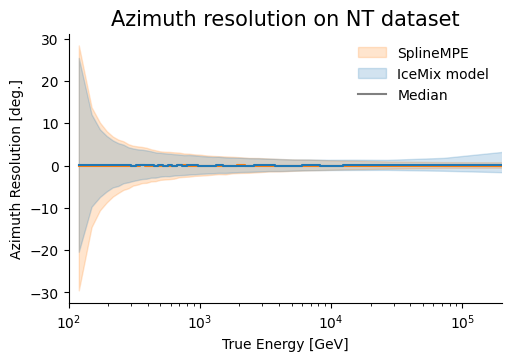

In [14]:
fig, ax = icemix_pred.plot_resolution_fancy('azimuth', include_residual_hist=False, step=True, x_limits=[1e2, 10**(5.3)], fill_area=True)


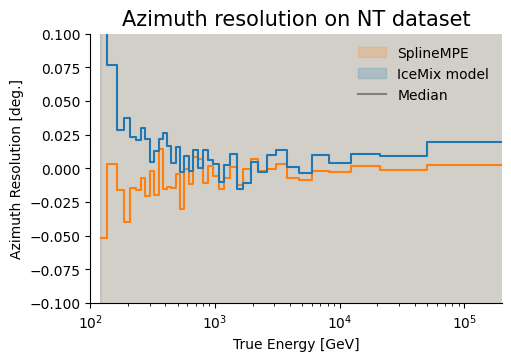

In [15]:
fig, ax = icemix_pred.plot_resolution_fancy('azimuth', include_residual_hist=False, step=True, y_limits = [-.1,.1], x_limits=[1e2, 10**(5.3)], fill_area=True)


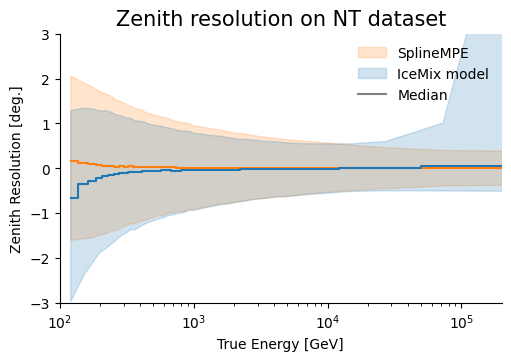

In [18]:
fig, ax = icemix_pred.plot_resolution_fancy('zenith', include_residual_hist=False, step=True, x_limits=[1e2, 10**(5.3)], fill_area=True, y_limits=[-3, 3])


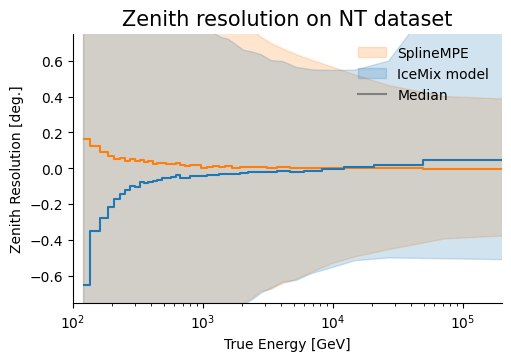

In [19]:
fig, ax = icemix_pred.plot_resolution_fancy('zenith', include_residual_hist=False, step=True, y_limits = [-.75,.75], x_limits=[1e2, 10**(5.3)], fill_area=True)


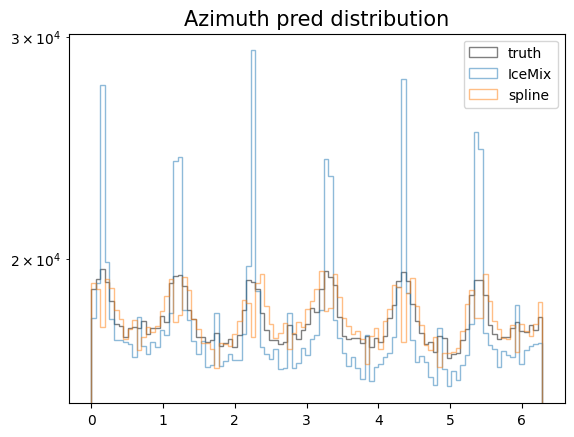

In [34]:
bins = np.linspace(0, 2*np.pi, 100)
plt.hist(icemix_pred.df_original[0]['azimuth'], bins=bins, alpha=0.5, label='truth', histtype='step', log=True, color='black')
plt.hist(icemix_pred.df_original[0]['azimuth_pred'], bins=bins, alpha=0.5, label='IceMix', histtype='step', log=True, color=icemix_pred.percentile_calculations['tracks'][icemix_pred.df_labels[1]]['colour'])
plt.hist(icemix_pred.df_original[0]['azimuth_spline_mpe_ic'], bins=bins, alpha=0.5, label='spline', histtype='step', log=True, color=icemix_pred.percentile_calculations['tracks'][icemix_pred.df_labels[0]]['colour'])
plt.title('Azimuth pred distribution')
plt.legend()
plt.show()

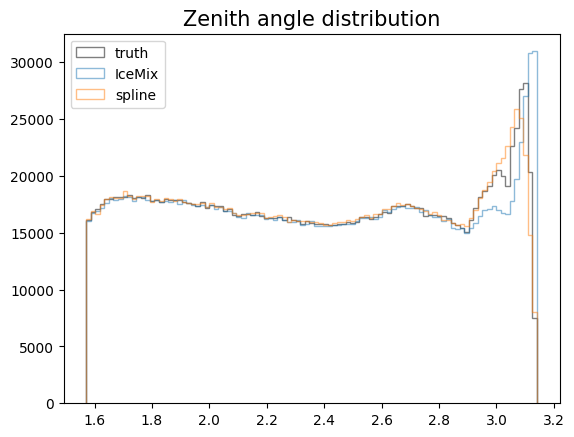

In [33]:
bins = np.linspace(np.pi/2, np.pi, 100)
plt.hist(icemix_pred.df_original[0]['zenith'], bins=bins, alpha=0.5, label='truth', histtype='step', color='black')
plt.hist(icemix_pred.df_original[0]['zenith_pred'], bins=bins, alpha=0.5, label='IceMix', histtype='step', color=icemix_pred.percentile_calculations['tracks'][icemix_pred.df_labels[1]]['colour'])
plt.hist(icemix_pred.df_original[0]['zenith_spline_mpe_ic'], bins=bins, alpha=0.5, label='spline', histtype='step', color=icemix_pred.percentile_calculations['tracks'][icemix_pred.df_labels[0]]['colour'])
plt.title('Zenith angle distribution')
plt.legend()
plt.show()

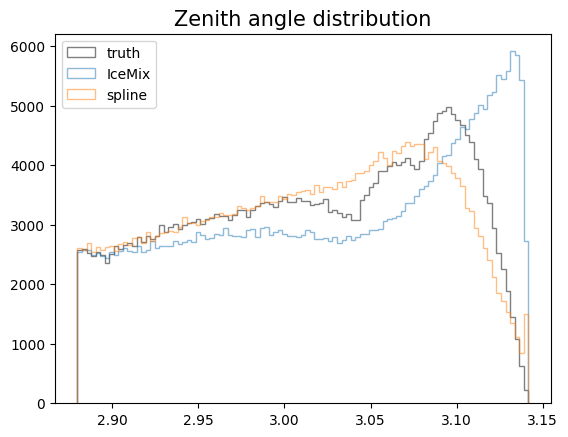

In [35]:
bins = np.linspace(np.pi*(11/12), np.pi, 100)
plt.hist(icemix_pred.df_original[0]['zenith'], bins=bins, alpha=0.5, label='truth', histtype='step', color='black')
plt.hist(icemix_pred.df_original[0]['zenith_pred'], bins=bins, alpha=0.5, label='IceMix', histtype='step', color=icemix_pred.percentile_calculations['tracks'][icemix_pred.df_labels[1]]['colour'])
plt.hist(icemix_pred.df_original[0]['zenith_spline_mpe_ic'], bins=bins, alpha=0.5, label='spline', histtype='step', color=icemix_pred.percentile_calculations['tracks'][icemix_pred.df_labels[0]]['colour'])
plt.title('Zenith angle distribution')
plt.legend()
plt.show()

In [14]:
from copy import deepcopy
import sqlite3
def calculate_opening_angle(df, key = 'gnn'):
    x = np.cos(df['azimuth']) * np.sin(df['zenith'])
    y = np.sin(df['azimuth']) * np.sin(df['zenith'])
    z = np.cos(df['zenith'])
    if key == 'gnn':
        dot_product = x*df['direction_x'] + y*df['direction_y'] + z*df['direction_z']
        norm = np.sqrt(df['direction_x']**2 + df['direction_y']**2 + df['direction_z']**2)
        angle = np.arccos(dot_product/norm)
    elif key == 'spline':
        x_spline = np.cos(df['azimuth_spline_mpe_ic']) * np.sin(df['zenith_spline_mpe_ic'])
        y_spline = np.sin(df['azimuth_spline_mpe_ic']) * np.sin(df['zenith_spline_mpe_ic'])
        z_spline = np.cos(df['zenith_spline_mpe_ic'])
        dot_product = x*x_spline + y*y_spline + z*z_spline
        norm = np.sqrt(x_spline**2 + y_spline**2 + z_spline**2)
        angle = np.arccos(dot_product/norm)
    return np.rad2deg(angle)

def add_spline_fit(original_df, db):
    df = deepcopy(original_df)
    df = df.sort_values('event_no').reset_index(drop = True)
    with sqlite3.connect(db) as con:
        # Read the table data into a Pandas DataFrame
        query = f"SELECT event_no, zenith_spline_mpe_ic, azimuth_spline_mpe_ic from spline_mpe_ic where event_no in {str(tuple(df['event_no']))}"
        truth = pd.read_sql(query,con).sort_values('event_no').reset_index(drop = True)
    
    # Add the spline fit to the DataFrame
    for column in truth.columns:
        if column not in df.columns:
            df[column] = truth[column]    
    return df

def add_prediction_azimuth_zenith( original_df):
    df = deepcopy(original_df)
    #df = df.sort_values(index_column).reset_index(drop = True)
    x_pred_label = 'direction_y'
    y_pred_label = 'direction_x'
    z_pred_label = 'direction_z'
        
    magnitude = np.sqrt(df[x_pred_label]**2 + df[y_pred_label]**2 + df[z_pred_label]**2)
    zenith_pred = np.arccos(df[z_pred_label] / magnitude)
    azimuth_pred = np.arctan2(df[y_pred_label], df[x_pred_label])
    
    df['zenith_pred'] = np.where(zenith_pred < 0, 2*np.pi + zenith_pred, zenith_pred)
    df['azimuth_pred'] = np.where(azimuth_pred < 0, 2*np.pi + azimuth_pred, azimuth_pred)
    df['zenith_pred'] = np.where(zenith_pred >= 2*np.pi, zenith_pred - 2*np.pi, zenith_pred)
    df['azimuth_pred'] = np.where(azimuth_pred >= 2*np.pi, azimuth_pred - 2*np.pi, azimuth_pred)
    
    return df

def add_prediction_azimuth_zenith_icemix(original_df):
    df = deepcopy(original_df)
    #df = df.sort_values(index_column).reset_index(drop = True)
    pred = np.stack([df['direction_x'].values, df['direction_y'].values, df['direction_z'].values], axis=-1)
    pred = np.divide(pred.astype(float), np.linalg.norm(pred.astype(float), ord=2, axis=-1, keepdims=True))
    
    zen = np.arccos(np.clip(pred[:, 2], -1, 1))
    
    f = np.divide(pred[:, :2], np.linalg.norm(pred[:, :2], ord=2, axis=-1, keepdims=True))
    
    az = np.arcsin(np.clip(f[:, 0], -1, 1))
    az = np.where(f[:, 1] > 0, az, np.pi - az)
    az = np.where(az > 0, az, az + 2.0 * np.pi)
    df['zenith_pred'] = zen
    df['azimuth_pred'] = az
    
    return df

## TITO model

In [2]:
df_selected = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_raw_tito_testFile5_light.csv')
df_selected_new = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_retrain_northern_light.csv')
df_retrained_from_northern = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_retrain_from_northern_epoch17_light.csv')
df_40e = pd.read_csv('/remote/ceph/user/l/llorente/tito_northern_retrain/model5_retrain_from_northern_epoch40_light.csv')

database_dir = '/mnt/scratch/rasmus_orsoe/databases/dev_northern_tracks_muon_labels_v3/'
database = database_dir+'dev_northern_tracks_muon_labels_v3_part_5.db'

all_df = [df_selected, df_40e]
all_labels = ['TITO model', 'TITO model fine-tuned']

In [3]:
tito_model = sensitivity_plots(all_df, all_labels, database, cascades_in_dataset=False, x_pred_label='direction_x', y_pred_label='direction_y', z_pred_label = 'direction_z')

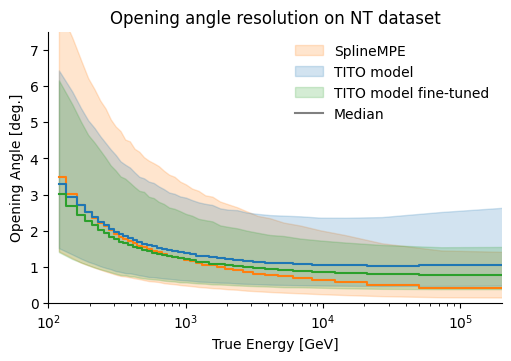

In [4]:
fig, ax = tito_model.plot_resolution_fancy('direction', include_residual_hist=False, step=True, y_limits=[0, 7.5], fill_area=True, x_limits=[1e2, 10**(5.3)])

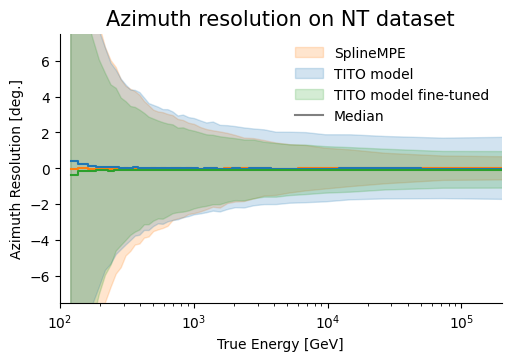

In [5]:
fig, ax = tito_model.plot_resolution_fancy('azimuth', include_residual_hist=False, step=True, y_limits=[-7.5, 7.5], fill_area=True, x_limits=[1e2, 10**(5.3)])

Text(0.5, 1.0, 'Distribution of Predicted - True Zenith Angles')

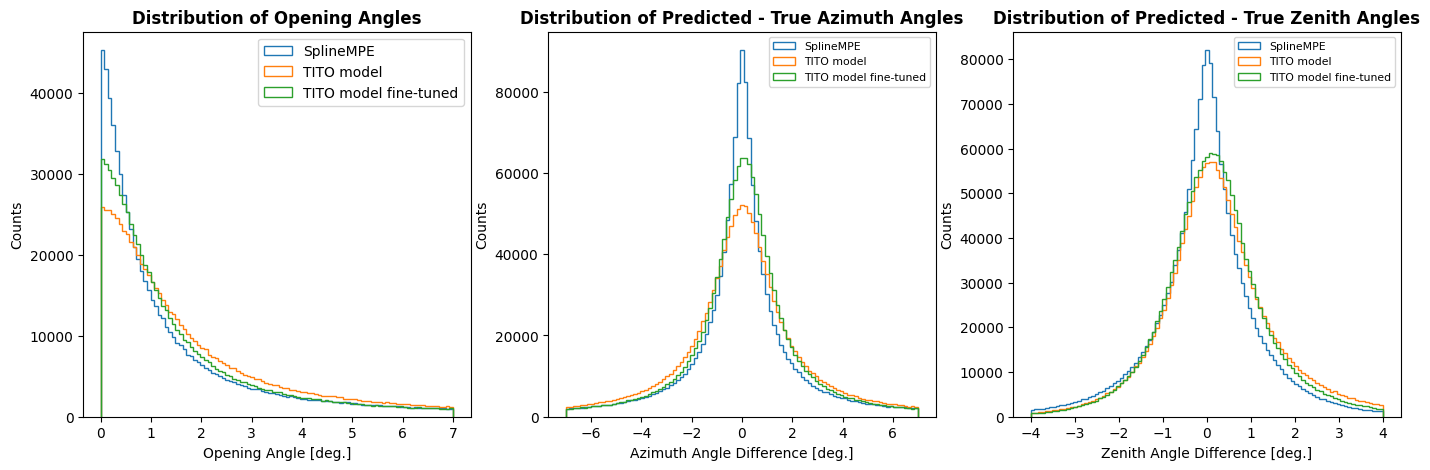

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

bins=np.linspace(0, 7, 100)
for label in tito_model.residual.keys():
    ax[0].hist(tito_model.residual[label], bins=bins, histtype = 'step', label = label, log=False)
ax[0].legend()
ax[0].set_xlabel('Opening Angle [deg.]')
ax[0].set_ylabel('Counts')
ax[0].set_title('Distribution of Opening Angles', fontsize=12, fontweight='bold')

bins=np.linspace(-7, 7, 100)
for i, label in enumerate(tito_model.residual.keys()):
    if i == 0:
        ax[1].hist(np.rad2deg(tito_model.df_original[0]['azimuth_spline_mpe_ic']-tito_model.df_original[0]['azimuth']), bins=bins, histtype = 'step', label = label, log=False)
    else:
        ax[1].hist(np.rad2deg(tito_model.df_original[i]['azimuth_pred']-tito_model.df_original[i]['azimuth']), bins=bins, histtype = 'step', label = label, log=False)
ax[1].legend(fontsize=7.8)
ax[1].set_xlabel('Azimuth Angle Difference [deg.]')
ax[1].set_ylabel('Counts')
ax[1].set_title('Distribution of Predicted - True Azimuth Angles', fontsize=12, fontweight='bold')

bins=np.linspace(-4, 4, 100)
for i, label in enumerate(tito_model.residual.keys()):
    if i == 0:
        ax[2].hist(np.rad2deg(tito_model.df_original[0]['zenith_spline_mpe_ic']-tito_model.df_original[0]['zenith']), bins=bins, histtype = 'step', label = label, log=False)
    else:
        ax[2].hist(np.rad2deg(tito_model.df_original[i]['zenith_pred']-tito_model.df_original[i]['zenith']), bins=bins, histtype = 'step', label = label, log=False)
ax[2].legend(fontsize=7.8)
ax[2].set_xlabel('Zenith Angle Difference [deg.]')
ax[2].set_ylabel('Counts')
ax[2].set_title('Distribution of Predicted - True Zenith Angles', fontsize=12, fontweight='bold')

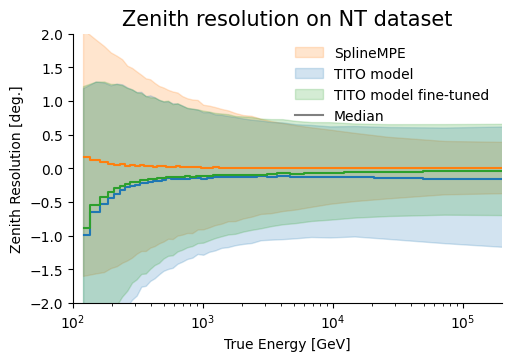

In [9]:
fig, ax = tito_model.plot_resolution_fancy('zenith', include_residual_hist=False, step=True, y_limits=[-2, 2], fill_area=True, x_limits=[1e2, 10**(5.3)])

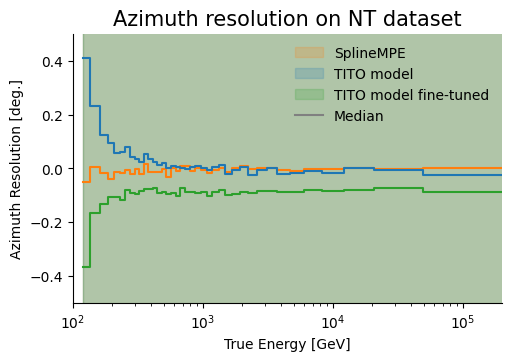

In [10]:
fig, ax = tito_model.plot_resolution_fancy('azimuth', include_residual_hist=False, step=True, y_limits=[-0.5, 0.5], fill_area=True, x_limits=[1e2, 10**(5.3)])

Text(0, 0.5, 'Count')

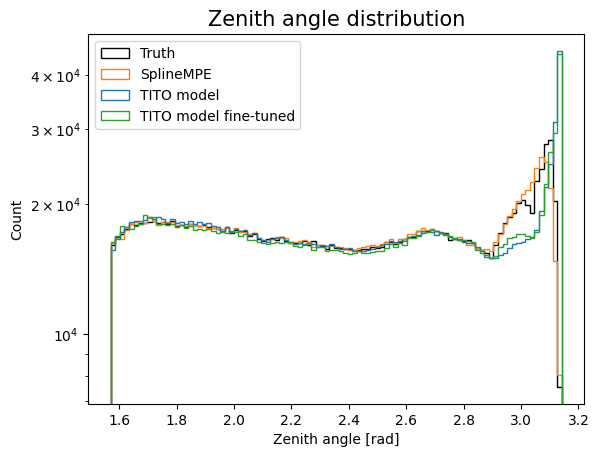

In [25]:
bins = np.linspace(np.pi/2, np.pi, 100)
colors = ['blue', 'red', 'green', 'black']
labels = ['raw']
plt.hist(df_i['zenith'], bins=bins, histtype='step', color='black', label='Truth')
plt.hist(tito_model.df_original[0]['zenith_spline_mpe_ic'], bins=bins, histtype='step', color=tito_model.percentile_calculations['tracks'][tito_model.df_labels[0]]['colour'], label=(tito_model.df_labels[0]), log=True)
for idx, df_i in enumerate(tito_model.df_original[1:]):
    plt.hist(df_i['zenith_pred'], bins=bins, histtype='step', color=tito_model.percentile_calculations['tracks'][tito_model.df_labels[idx+1]]['colour'], label=(tito_model.df_labels[idx+1]), log=True)
    

plt.legend()

plt.title('Zenith angle distribution')
plt.xlabel('Zenith angle [rad]')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

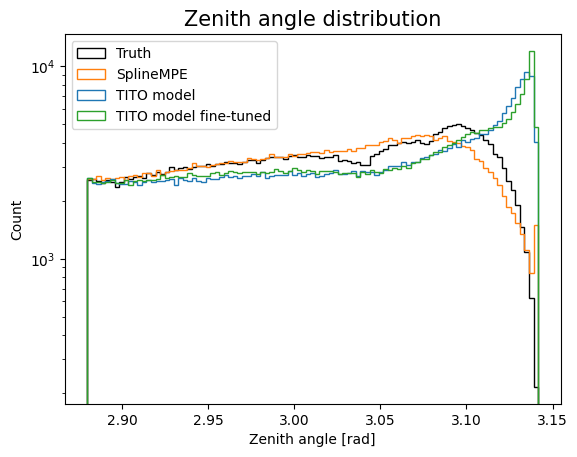

In [30]:
bins = np.linspace(np.pi*(11/12), np.pi, 100)
colors = ['blue', 'red', 'green', 'black']
labels = ['raw']
plt.hist(df_i['zenith'], bins=bins, histtype='step', color='black', label='Truth')
plt.hist(tito_model.df_original[0]['zenith_spline_mpe_ic'], bins=bins, histtype='step', color=tito_model.percentile_calculations['tracks'][tito_model.df_labels[0]]['colour'], label=(tito_model.df_labels[0]), log=True)
for idx, df_i in enumerate(tito_model.df_original[1:]):
    plt.hist(df_i['zenith_pred'], bins=bins, histtype='step', color=tito_model.percentile_calculations['tracks'][tito_model.df_labels[idx+1]]['colour'], label=(tito_model.df_labels[idx+1]), log=True)
    

plt.legend()

plt.title('Zenith angle distribution')
plt.xlabel('Zenith angle [rad]')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

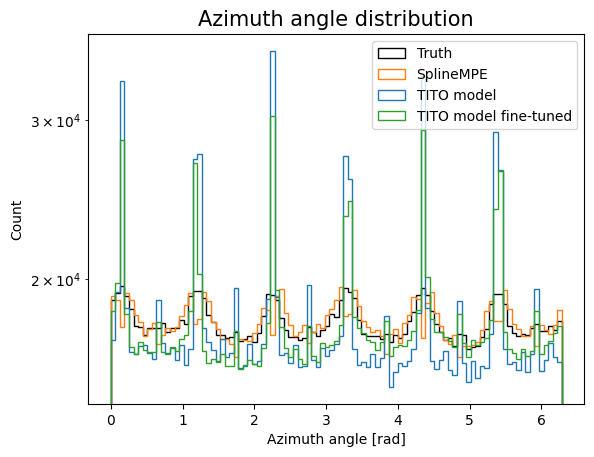

In [88]:
bins = np.linspace(0, 2*np.pi, 100)
colors = ['blue', 'red', 'green', 'black']

plt.hist(df_i['azimuth'], bins=bins, histtype='step', color='black', label='Truth')
plt.hist(tito_model.df_original[0]['azimuth_spline_mpe_ic'], bins=bins, histtype='step', color=tito_model.percentile_calculations['tracks'][tito_model.df_labels[0]]['colour'], label=(tito_model.df_labels[0]), log=True)
for idx, df_i in enumerate(tito_model.df_original[1:]):
    plt.hist(df_i['azimuth_pred'], bins=bins, histtype='step', color=tito_model.percentile_calculations['tracks'][tito_model.df_labels[idx+1]]['colour'], label=(tito_model.df_labels[idx+1]), log=True)
    

plt.legend(loc='upper right')

plt.title('Azimuth angle distribution')
plt.xlabel('Azimuth angle [rad]')
plt.ylabel('Count')

Text(0.5, 1.0, 'Opening angle counts')

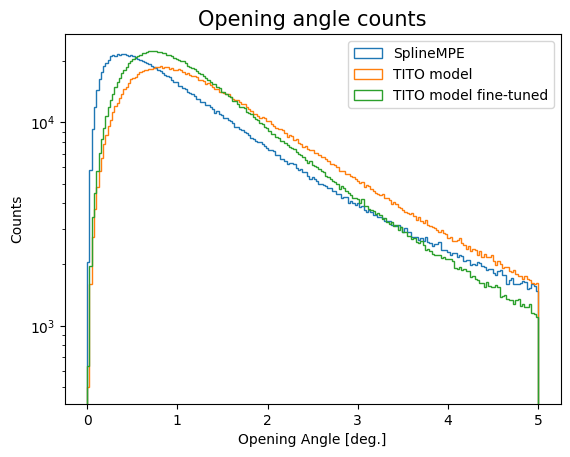

In [94]:
bins=np.linspace(0, 5, 200)
for label in tito_model.residual.keys():
    plt.hist(tito_model.residual[label], bins=bins, histtype = 'step', label = label, log=False)
plt.legend()
plt.xlabel('Opening Angle [deg.]')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Opening angle counts')